In [3]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings_size = 10

inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [7]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [8]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [39]:
print(variational_encoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28)]             0         []                            
                                                                                                  
 flatten (Flatten)           (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 150)                  117750    ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 100)                  15100     ['dense[0][0]']               
                                                                                              

In [40]:
print(variational_decoder.summary())


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dense_5 (Dense)             (None, 150)               15150     
                                                                 
 dense_6 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 134634 (525.91 KB)
Trainable params: 134634 (525.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
    axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)

In [33]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 100
        reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(z_mean, z_logvar):
        kl_loss = -0.5 *tf.reduce_sum(1.0 + z_logvar -tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.reduce_sum(1.0 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [34]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
variational_ae.compile(optimizer=opt, loss=loss_func(codings_mean, codings_log_var))
history = variational_ae.fit(X_train, X_train, epochs=50, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/50
430/430 [==============================] - 5s 6ms/step - loss: 6.2517 - val_loss: 6.2918
Epoch 2/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1977 - val_loss: 6.2777
Epoch 3/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1878 - val_loss: 6.2723
Epoch 4/50
430/430 [==============================] - 3s 7ms/step - loss: 6.1822 - val_loss: 6.2661
Epoch 5/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1779 - val_loss: 6.2639
Epoch 6/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1744 - val_loss: 6.2602
Epoch 7/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1714 - val_loss: 6.2580
Epoch 8/50
430/430 [==============================] - 2s 5ms/step - loss: 6.1686 - val_loss: 6.2556
Epoch 9/50
430/430 [==============================] - 3s 6ms/step - loss: 6.1661 - val_loss: 6.2535
Epoch 10/50
430/430 [==============================] - 2s 6ms/step - loss: 6.1639 - val_loss: 6.2514

In [35]:
import numpy as np

def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")



1/1 [==============================] - 0s 55ms/step


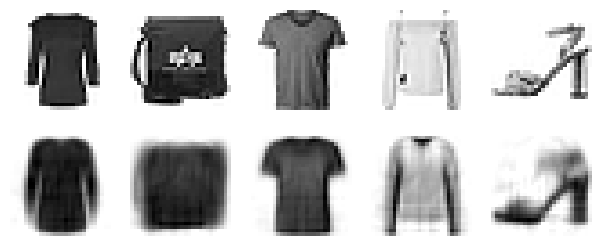

In [37]:
plot_reconstructions(variational_ae)
plt.show()

# Testing Phase

In [21]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[35, codings_size])
images = variational_decoder(codings).numpy()

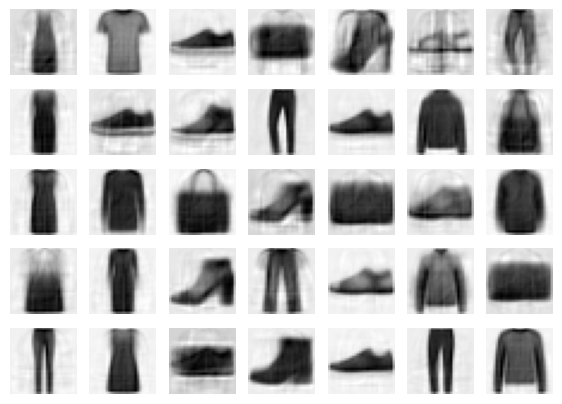

In [22]:
# extra code – this cells generates and saves Figure 17-12

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 7)
save_fig("vae_generated_images_plot", tight_layout=False)
plt.show()

# Plot Latent space

1719/1719 [==============================] - 11s 7ms/step


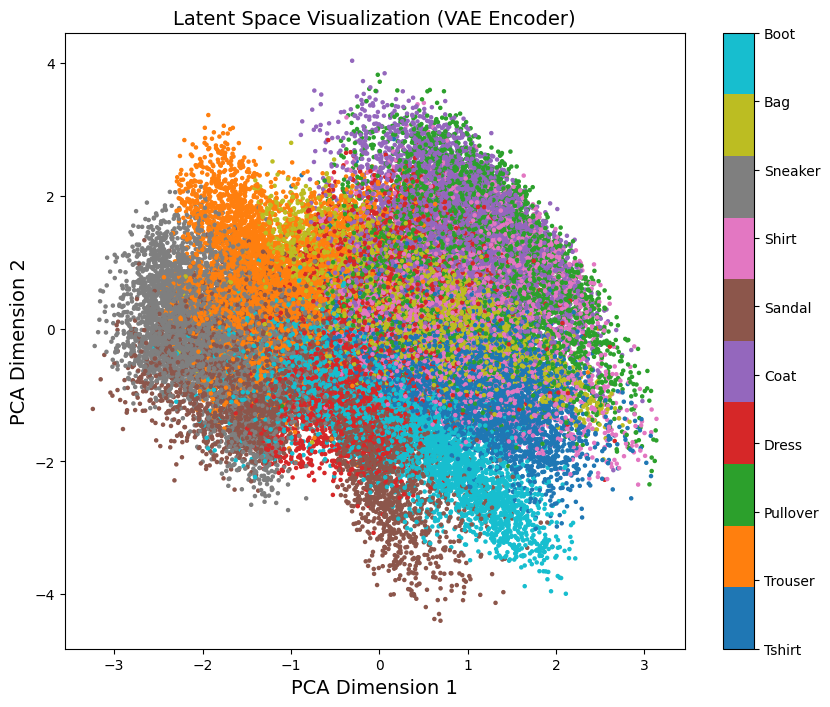

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. PASS X_train TO ENCODER
z_mean, z_log_var, z = variational_encoder.predict(X_train)

# 2. REDUCE LATENT SPACE TO 2D
pca = PCA(n_components=2)
z_2d = pca.fit_transform(z_mean)

# 3. VISUALIZE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_train, cmap="tab10", s=5)

cbar = plt.colorbar(scatter)
cbar.set_ticks(range(10))
cbar.set_ticklabels([
    "Tshirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Boot"
])

plt.title("Latent Space Visualization (VAE Encoder)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()
